# MLA'18 Twitter analysis and wordcloud generation
Below is the code I have been using to generate the graphs and wordclouds associated with the 2018 Medical Library Association annual conference in Atlanta, GA

I have been hacking this together over a number of conferences, and over a period of time. By request, I am sharing it here for the enlightenment and curiosity of others. I have attempted to clean it up a little bit, and add some cursory comments to help people understand which parts are doing what. However, this is not intended to be a tutorial, nor do I claim a deep understanding of every element of what I utilize here. I am only beginning my journey with Natural Language Processing. 

So to anyone who ventures below: Thanks for having a look! I always welcome advice and suggestions from peers and veterans, so feel free to contribute, or shoot me an email. 

Cheers and regards!

Peter

```
Peter Oxley, PhD
Associate Director of Research Services

Weill Cornell Medicine
Information Technologies and Services
Samuel J. Wood Library & C.V. Starr Biomedical Information Center
1300 York Avenue Room D-120
New York, NY 10065-4896
(P) 646-962-2576
 
pro2004@med.cornell.edu
```

## Getting started
This was originally run in a Jupyterlab notebook. For those interested in giving it a go:

1. Download this notebook from https://github.com/oxpeter/mlanet18_twitter/archive/master.zip

2. Unzip the folder that downloads

1. Download Anaconda from https://www.anaconda.com/download/ (select your operating system, then click 'Download'

2. Run the Anaconda installer you just downloaded. When it asks which version of Python to install, select 3.6 (or higher)

3. Open Anaconda

4. Open Jupyterlab (click 'Launch')

5. In Jupyterlab, on the left-hand "Files" panel, navigate to where you downloaded this notebook folder

6. The notebook should now load!

7. You will need to install a number of extra modules for this notebook to run. You can do so in Anaconda by: 
    1. clicking on the Environments panel on the left
    2. selecting "all" instead of "installed" modules
    3. searching for the modules in the right panel 
    4. selecting the check box next to each module name
    5. clicking "apply" in the bottom right
    6. it will tell you all the modules (and their dependencies) it wants to install. Click 'OK'
    
8. An alternative means of installing is to use the terminal, with the command:
    ```conda install module1 module2 module3```
    
You will need to install the following modules (Anaconda will already have installed some of these by default):

* pandas
* numpy
* matplotlib
* seaborn
* pillow
* nltk
* 

### Using Python in Jupyterlab
This Jupyter notebook has been built to run on a python 3 'kernel'. That means you can enter python code into the code cells, and it will be able to execute as python.

To execute code, select the cell(s) by clicking inside, then either:

* Choose "Run Selected Cells" from the Command tab on the left
* Click the run button (triangle) at the top of the notebook
* Press "Shift + Enter"


## Import the needed modules

In [1]:
# import basic modules
from collections import Counter
import os
from os import path
import re

In [2]:
# import graphing modules (and configure to display in the notebook)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from PIL import Image

In [3]:
# import modules for working with tabular data
import numpy as np
import pandas as pd

In [4]:
# import nltk for importing Twitter data, and performing NLP
from nltk.twitter import Query, Streamer, Twitter, TweetViewer, TweetWriter, credsfromfile
from nltk.tokenize import TweetTokenizer
from nltk.twitter.common import json2csv_entities

## Query Twitter for hashtag



Tweets are pulled using [NTLK's Twitter module](http://www.nltk.org/howto/twitter.html). The key steps are as follows:


```oauth = credsfromfile()``` gets the stored API key information from the `credentials.txt` file in the directory specified by the TWITTER environment variable. You can create your API key using the instructions from http://www.nltk.org/howto/twitter.html. 

This authentication info is passed to `Query()`, which calls twitter's [Search API](https://dev.twitter.com/rest/public). This lets us query past tweets. Although Twitter delivers tweets as [JSON](http://www.json.org) objects, the Python client encodes them as dictionaries.



#### Set the environment variable that points to the Twitter credentials file

In [5]:
twitter_credentials = path.join(os.getcwd(),'twitter-files')

In [6]:
%env TWITTER {twitter_credentials}

env: TWITTER=/Users/poxley/Documents/6. Workforce/conferences/MLA 2018/twitter_analysis/twitter-files


In [64]:
oauth = credsfromfile()
client = Query(**oauth)
tweets = client.search_tweets(keywords='#mlanet18 OR #mlanet2018', limit=10000)

Twitter's own documentation [provides a useful overview of all the fields in the JSON object](https://dev.twitter.com/overview/api/tweets) and it may be helpful to look at this [visual map of a Tweet object](http://www.scribd.com/doc/30146338/map-of-a-tweet).

Since each Tweet is converted into a Python dictionary, it's straightforward to just show a selected field, such as the value of the `'text'` key.

In [65]:
# saving tweets to json file
import json

In [66]:
json_tweets = "tweets.mlanet18.json"

In [67]:
handle = open(json_tweets, 'w')
for i,t in enumerate(tweets):
    handle.write(json.dumps(t) + '\n')
    # print(t['text'])
handle.close()
print(i, "tweets written to {}".format(json_tweets))

No more Tweets available through rest api
5785 tweets written to tweets.mlanet18.json


### Convert .json to .csv and extract twitter metadata

If we want to carry out analyses on the tweets, we have to work directly with the file rather than via the corpus reader.

The function `json2csv()` takes as input a file-like object consisting of Tweets as line-delimited JSON objects and returns a file in CSV format. The third parameter of the function lists the fields that we want to extract from the JSON. All the fields available are described in [the official Twitter API](https://dev.twitter.com/overview/api/tweets).

In [68]:
from nltk.twitter.common import json2csv

The following will generate a CSV file including most of the metadata together with the id of the user who has published it.

In [69]:
with open(json_tweets) as fp:
    json2csv(fp, 'tweets_mlanet18_metadata.csv',
            ['created_at', 'favorite_count', 'id', 'in_reply_to_status_id', 
            'in_reply_to_user_id', 'retweet_count', 'retweeted', 
            'text', 'truncated', 'user.id', 'user.screen_name'])

The first nine elements of the list are attributes of the Tweet, while the last two, `user.id` and `user.screen_name`, take the user object associated with the Tweet, and retrieve the attributes in the list (in this case the id and twitter handle). The object for the Twitter user is described in the  [Twitter API for users](https://dev.twitter.com/overview/api/users).

Additionally, when a Tweet is actually a retweet, the original tweet can be also fetched from the same file, as follows:

In [70]:
with open(json_tweets) as fp:
    json2csv_entities(fp, 'tweets.mlanet18.original_tweets.csv',
                        ['id'], 'retweeted_status', ['created_at', 'favorite_count', 
                        'id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweet_count',
                        'text', 'truncated', 'user.id'])

Here the first id corresponds to the retweeted Tweet, and the second id to the original Tweet.

### Read CSV data into a [Pandas](http://pandas.pydata.org/) Dataframe

In [71]:
tweets = pd.read_csv('tweets_mlanet18_metadata.csv', index_col=2, header=0, encoding="utf8")
# adjust to local time (time reported is UTC)
tweets.created_at = pd.to_datetime(tweets.created_at) - pd.DateOffset(hours=4) 
tweets.head(3)

,created_at,favorite_count,in_reply_to_status_id,in_reply_to_user_id,retweet_count,retweeted,text,truncated,user.id,user.screen_name
id,,,,,,,,,,
998951965756358657,2018-05-22 11:41:22,0,NaN,NaN,0,False,All of Us is designed to help engage medical l...,False,39556136,hurstej
998951920554397698,2018-05-22 11:41:12,0,NaN,NaN,2,False,RT @pfanderson: @JoeBabaian @Colin_Hung @nicki...,False,787737762,JoeBabaian
998951899486392320,2018-05-22 11:41:07,0,9.989519e+17,30585609.0,0,False,The concurrent public librarian events happeni...,False,30585609,NoetheMatt


Tokenize the tweets and append the list to the dataframe

In [72]:
tknzr = TweetTokenizer(preserve_case=False)

In [73]:
tweets["tknzd"] = tweets.text.apply(tknzr.tokenize)

## Filter tweets
### filter tweets by time sent

In [74]:
# filter for only tweets that occur within a specific time period
after_hours = tweets[(tweets.created_at.dt.hour >= 18) |
                      (tweets.created_at.dt.hour < 7)
                    ]
daytime_hours = tweets[(tweets.created_at.dt.hour >= 7) |
                       (tweets.created_at.dt.hour < 18)
                      ]
monday_daytime = tweets[(tweets.created_at >= "05-21-2018 05:00:00") & 
                        (tweets.created_at < "05-21-2018 19:00:00")
                       ]
monday_nighttime = tweets[(tweets.created_at >= "2018-05-21 19:00:00") &
                          (tweets.created_at < "2018-05-22 07:00:00")
                       ]

business_tweets = tweets[(tweets.created_at >= "2018-05-23 09:00:00") &
                         (tweets.created_at < "2018-05-23 10:40:00")
                        ]

will_power_tweets = tweets[(tweets.created_at >= "2018-05-20 10:00:00") &
                         (tweets.created_at < "2018-05-20 11:00:00")
                        ]

janet_doe_time = tweets[(tweets.created_at >= "2018-05-21 09:00:00") &
                         (tweets.created_at < "2018-05-21 10:05:00")
                        ]

### get word lists and filter tweets by content

In [75]:
retweet_mask = tweets.text.str.contains("^RT")

allwords = [w for wlists in tweets.tknzd.values for w in wlists]

# remove any retweets (to get the distribution of original content)
no_RT_words = [w  for wlists in tweets[~retweet_mask].tknzd.values for w in wlists ]

# get the word lists for day and night
after_hours_noRT = [w  for wlists in after_hours[~after_hours.text.str.contains("^RT")].tknzd.values for w in wlists ]
day_hours_noRT = [w  for wlists in daytime_hours[~daytime_hours.text.str.contains("^RT")].tknzd.values for w in wlists ]
 
after_hours_wRT = [w  for wlists in after_hours.tknzd.values for w in wlists ]
day_hours_wRT = [w  for wlists in daytime_hours.tknzd.values for w in wlists ]


# get words from other specific events
monday_day_wRT = [w  for wlists in monday_daytime.tknzd.values for w in wlists ]
monday_night_wRT = [w  for wlists in monday_nighttime.tknzd.values for w in wlists ]

business_meeting = [w  for wlists in business_tweets.tknzd.values for w in wlists ]

wp_tweets = will_power_tweets[will_power_tweets.text.str.contains("@wpwrs|powers|McGovern", case=False)]
will_power = [w  for wlists in wp_tweets.tknzd.values for w in wlists ]

tweeters_words = [re.sub(":|(\'s)", "", w) for wlists in tweets.text.apply(lambda s: s.split()).values for w in wlists if w[0]=="@"]

pfanderson = [w for wlists in tweets[tweets['user.screen_name']=='pfanderson'].tknzd.values for w in wlists]

janet_doe_wRT = [w  for wlists in janet_doe_time.tknzd.values for w in wlists ]

## Analyse tweets
First, we will summarize the tweet data for all Twitter users. We want to look at the type of content of their tweets, according to whether they are original tweets, replies to another tweet, or a retweet, as well as the timing of users' tweets. 

First, we create some new columns to indicate the type of tweet, or the hour of the day it was made:

In [76]:
tweets['is_retweet'] = tweets.tknzd.apply(lambda x: True if x[0]=="rt" else False)
tweets['is_reply'] = tweets.in_reply_to_user_id.apply(lambda x: False if pd.isna(x) else True)
tweets["creation_hour"] = tweets.created_at.dt.hour

Now we create the summary table:

In [77]:
tweet_analysis = tweets.groupby("user.screen_name").agg({'retweet_count':np.mean,
                                                        'favorite_count':np.mean,
                                                        'creation_hour':np.mean,
                                                        'created_at':np.count_nonzero,
                                                        'is_retweet':np.sum,
                                                        'is_reply':np.sum,
                                                       })
tweet_analysis['is_original'] = (tweet_analysis.created_at - tweet_analysis.is_reply - tweet_analysis.is_retweet)

In [78]:
def get_prolifics(top=10):
    """
    This function pulls out the top n users by total tweets, original content, replies, 
    and retweets. It returns all these sub-tables, as well as a concatenation of all of
    the above, which encompasses all users who were included in at least one of the 
    above lists.
    """
    
    # set the top n list:
    most_prolific = tweet_analysis.sort_values('created_at',ascending=False).head(top)
    most_engaging = tweet_analysis.sort_values('is_reply',ascending=False).head(top)
    most_distributive = tweet_analysis.sort_values('is_retweet',ascending=False).head(top)
    most_original = tweet_analysis.sort_values('is_original' ,ascending=False).head(top)

    # tweet_analysis[tweet_analysis.index.isin()]
    top_performers_list = pd.concat([most_prolific, most_engaging, most_distributive, most_original], axis=0).index.unique()
    df_topperf = tweet_analysis[tweet_analysis.index.isin(top_performers_list)].sort_values('created_at',ascending=False)
    return most_prolific, most_engaging, most_distributive, most_original, df_topperf

### Create facet plot
Created a faceted plot of all the top 10 groups:

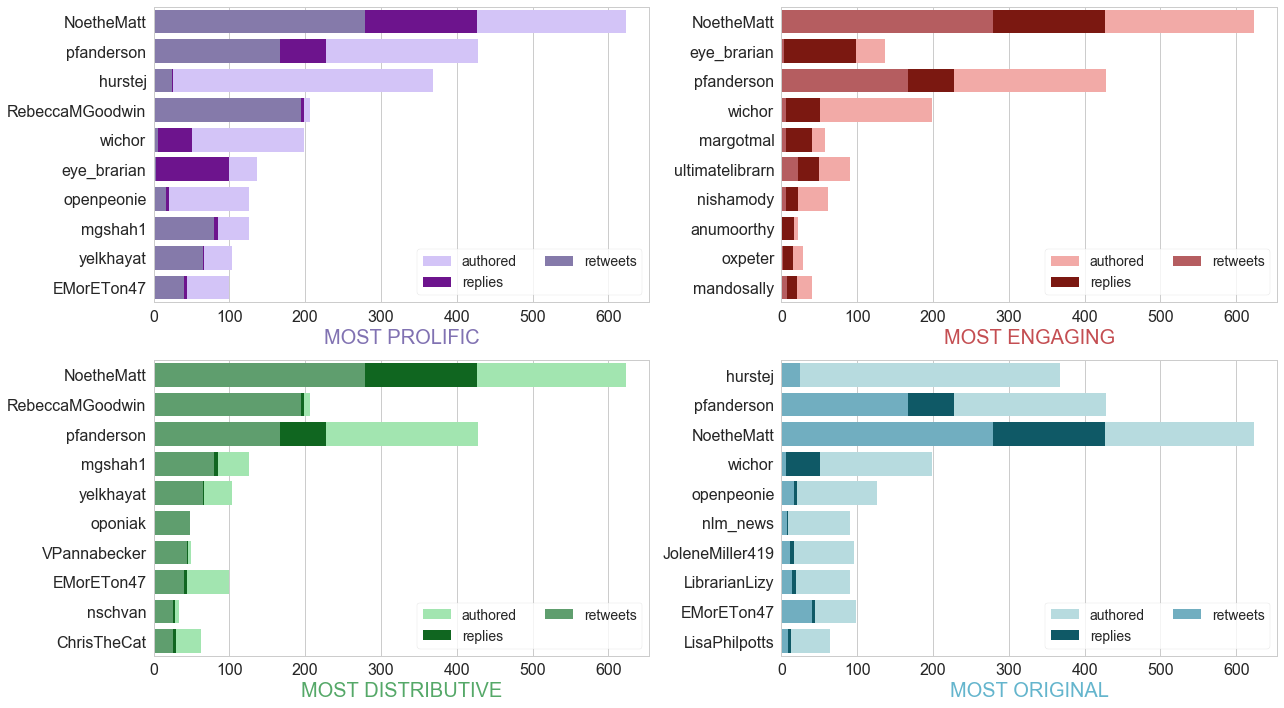

In [79]:
most_prolific, most_engaging, most_distributive, most_original, df_topperf = get_prolifics(10)
sns.set(style="whitegrid")
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

for ax,df,xlab,c in zip([ax1,ax2,ax3,ax4], 
                      [most_prolific, most_engaging, most_distributive, most_original],
                      ["PROLIFIC", "ENGAGING", "DISTRIBUTIVE", "ORIGINAL"],
                      ['m', 'r', 'g', 'c']
                     ):
    plt.sca(ax)
    sns.set_color_codes("pastel")
    sns.barplot(y=df.index, x=df['created_at'], ax=ax, color=c, label="authored")
    sns.set_color_codes("dark")
    sns.barplot(y=df.index, x=df['is_retweet']+df['is_reply'], ax=ax, color=c, label="replies")
    sns.set_color_codes("deep")
    sns.barplot(y=df.index, x=df['is_retweet'], ax=ax, color=c, label="retweets")

    # customize plot settings
    ax.legend(ncol=2, loc="lower right", frameon=True, fontsize=14)
    plt.xlabel("MOST {}".format(xlab), fontsize=20, color=c)
    plt.ylabel("")
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

# save and display
plt.tight_layout()
plt.savefig("graph_most_prolific_facet.png")
plt.show()

### Create a single aggregate plot of the above
Because most users are common to all plots, we can pool these four graphs into one. 

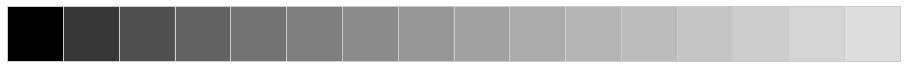

In [80]:
# to overlap these graphs together, we need a greyscale for elements that are not part of the top n users
sns.palplot(sns.cubehelix_palette(16, start=0.2, rot=0.7, gamma=0.5, hue=0, dark=0, light=.75, reverse=True))
cmap = sns.cubehelix_palette(16, start=0.2, rot=0.7, gamma=0.5, hue=0, dark=0, light=.75, reverse=True, as_cmap=True)

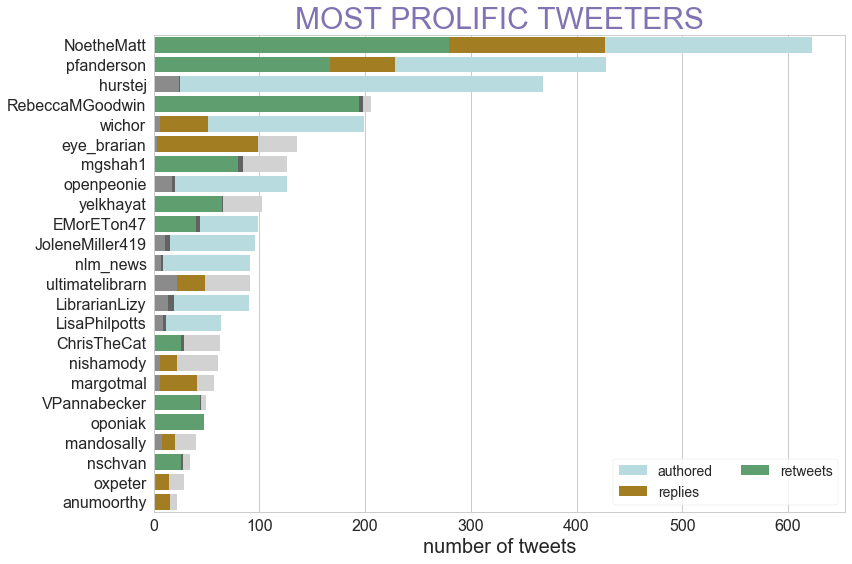

In [81]:
# get data
most_prolific, most_engaging, most_distributive, most_original, df_topperf = get_prolifics(10)

sns.set(style="whitegrid")
cmap = sns.cubehelix_palette(16, start=0.2, rot=0.7, gamma=0.5, hue=0, dark=0, light=.75, reverse=True, as_cmap=True)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

sns.set_color_codes("pastel")
sns.barplot(y=df_topperf.index, 
            x=df_topperf['created_at'], 
            palette=list(map(lambda x: 'c' if x else cmap(0.9), 
                             df_topperf.index.isin(most_original.index))),
            ax=ax, label="authored", 
           )

sns.set_color_codes("dark")
sns.barplot(y=df_topperf.index, 
            x=df_topperf['is_retweet']+df_topperf['is_reply'], 
            palette=list(map(lambda x: 'y' if x else cmap(0.2), 
                             df_topperf.index.isin(most_engaging.index))), 
            label="replies", ax=ax, 
           )

sns.set_color_codes("deep")
sns.barplot(y=df_topperf.index, 
            x=df_topperf['is_retweet'], 
            palette=list(map(lambda x: 'g' if x else cmap(0.4), 
                             df_topperf.index.isin(most_distributive.index))), 
            ax=ax, label="retweets"
           )

# customize plot settings
ax.legend(ncol=2, loc="lower right", frameon=True, fontsize=14)
plt.title("MOST PROLIFIC TWEETERS", fontsize=30, color='m')
plt.ylabel("")
plt.xlabel("number of tweets", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# save and display
plt.tight_layout()
plt.savefig("graph_most_prolific.png")
plt.show()

### Create Bokeh plot
This is just my first foray into Bokeh plots, and is pretty crude.

In [82]:
import bokeh.plotting as bplt #import figure, output_file, show
from bokeh.models import ColumnDataSource, CDSView, IndexFilter, HoverTool
from bokeh.layouts import gridplot
from math import pi

In [83]:
most_prolific, most_engaging, most_distributive, most_original, df_topperf = get_prolifics(30)
bokeh_data = df_topperf.reset_index().rename(columns={"user.screen_name":"user", "created_at":"total_tweets"})
bokeh_data['rt_rply'] = bokeh_data.is_reply + bokeh_data.is_retweet
bokeh_data.tail(3)

,user,retweet_count,favorite_count,creation_hour,total_tweets,is_retweet,is_reply,is_original,rt_rply
58,CarolinaFan1982,0.75,3.625,10.50,8,0.0,6.0,2.0,6.0
59,rbharrison85,0.20,1.400,14.20,5,0.0,3.0,2.0,3.0
60,lisam695,0.00,3.000,16.25,4,0.0,3.0,1.0,3.0


In [84]:
# output to static HTML file
bplt.output_notebook()
bplt.output_file("prolific_tweeters_bokeh.html")

# define data source
source = ColumnDataSource(data=bokeh_data)

# define hover output:
hover = HoverTool(tooltips=[("","@user",),
                            ("mean hour", "@creation_hour"),
                            ("total tweets", "@total_tweets"),
                            ("original", "@is_original"),
                            ("replies", "@is_reply"),
                            ("retweets", "@is_retweet"),
                            ],
                  mode='vline',
                  names=['Retweets']
                 )

tools = ["pan","box_zoom","box_select", hover, "reset"]
p = bplt.figure(plot_height=600, 
                plot_width=1200, 
                x_range=bokeh_data.user.values,
                tools=tools,
               )

p.vbar(bottom='rt_rply',top='total_tweets', 
       x='index', width=0.8,
       hover_color="#249DF0", fill_color='#F35340', line_color='#F35340',
       source=source,
       legend="Original", name="Original",
      )
p.vbar(bottom='is_retweet', top='rt_rply', 
       x='index', width=0.8, 
       hover_color="#249DF0", fill_color='#FF9F0C', line_color='#FF9F0C',
       source=source,
       legend="Replies", name="Replies",
      )
p.vbar(bottom=0, top='is_retweet',
       x='index', width=0.8,
       hover_color="#249DF0", fill_color='#FFE22B', line_color='#FFE22B',
       source=source,
       legend="Retweets", name="Retweets",
      )

p.xaxis.major_label_orientation = pi/4

# show the results
bplt.show(p)

Loading BokehJS ...

### Look at tweets by time
both number of tweets by hour, and tweet content at different periods of the day

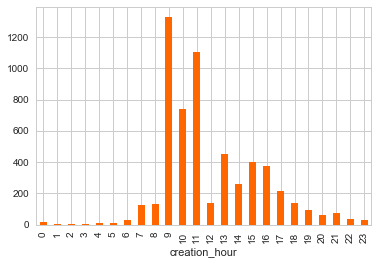

In [85]:
tweets.groupby("creation_hour").count()["user.id"].plot.bar(color="#ff6600")
plt.savefig("tweets_by_hour.png")

### Most tweets and most mentions
This was an earlier attempt at plotting the above, but it also shows the most popular users by mention, so I'm keeping it here for reference.

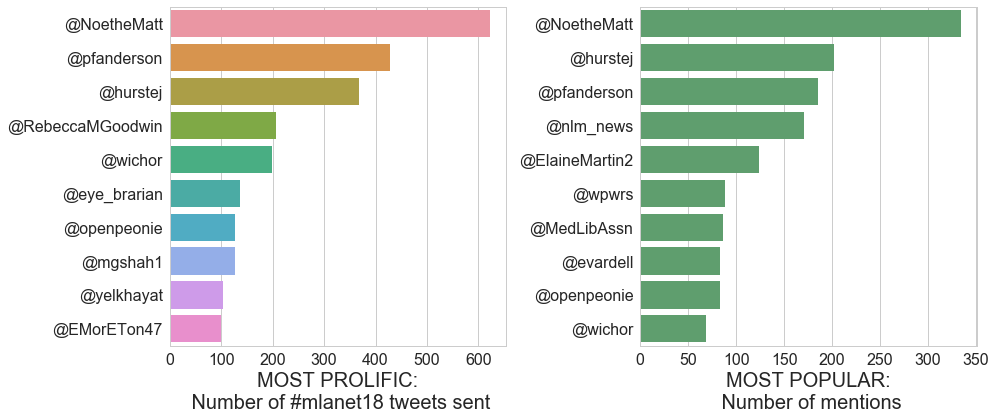

In [86]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

data = tweets.groupby('user.screen_name').size().sort_values(ascending=False).head(10)
sns.barplot(y=["@"+u for u in data.index], x=data.values, ax=ax1) # may need to add the @ back in again...

# customize plot settings
plt.xlabel("MOST PROLIFIC:\n Number of #mlanet18 tweets sent", fontsize=20)
plt.ylabel("")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# add most mentioned people:
ax2 = fig.add_subplot(122)

s_twhandles = pd.Series(Counter(tweeters_words))
data = s_twhandles.sort_values(ascending=False).head(10)
sns.barplot(y=data.index, x=data.values, color='g', ax=ax2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("MOST POPULAR:\n Number of mentions", fontsize=20)

# save and display
plt.tight_layout()
plt.savefig("graph_most_prolific_popular.png")
plt.show()

## Build wordcloud

### Set options for wordle
These variables determine:
* (tokenized) word set
* output file to save word cloud to
* image file to use as mask

In [30]:
text = " ".join(allwords)
wordle_output_gif = "mla18_tweets_phoenix_all_Sunday_arvo.gif"
mask_image = "mask_two_people.jpg"

### Create stopword set
customized to add the common twitter elements that we don't want cluttering our wordcloud

In [31]:
def get_stopwords(stop_tweeters=True, extras=[]):
    # start with a standard set of stopwords:
    stopwords = set(open("stopwords.txt", 'r').readline().split(','))

    if stop_tweeters:
        # remove all the twitter handles from the users
        twitter_handle_names = list(tweets["user.screen_name"].values)
    else:
        twitter_handle_names = []
        
    manual_stopwords = ["https","co","rt","don't","i'm","you're","i've", "it's",
              "nUaDgbMNgU","kuLfgZoEL0","kdfGPTtRow","PQQfWNyNGh","pe54vvn", "zSvLp3M55T",
              "7YNot1GvdT","stLeWaRLlF", "Shsapk86wb", "BX9Nz83yFh",
              "mlanet18",         
                       ]
    for w in twitter_handle_names + manual_stopwords + extras:
        stopwords.add(w)
    return stopwords

### Create image mask
Colored areas of the image will be where words get placed. White areas will be left blank

In [32]:
# create image mask
mask = np.array(Image.open(mask_image))

### create a nice colormap
pull the desired cmap values from some of the existing cmaps on matplotlib, then smash them together into a new one (I don't have to worry about transitions between them, since the colors are being random selected from the full range anyway).

This code is based on the answer given in https://stackoverflow.com/questions/39024331/modifying-python-colormaps-to-single-value-beyond-a-specific-point

In [89]:
# get the darker colours from the "Reds" and "autumn" cmaps:
colors2 = plt.cm.hot(np.linspace(0, 0.5, 128))
colors3 = plt.cm.autumn(np.linspace(0, 0.5, 256))

# stacking the 2 arrays row-wise
colors = np.vstack((colors3, colors2))

# generating a smoothly-varying LinearSegmentedColormap
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', colors)


In [34]:
colors = plt.cm.plasma(np.linspace(0,0.9,256))
cmap3 = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

Another method is to use seaborn's choose_cubehelix_palette(), or define it manually. I did not find a satisfactory set of intense colors for my purpose this time round:

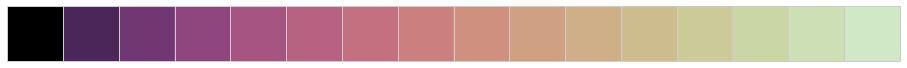

In [35]:
phoenix_cmap = sns.palplot(sns.cubehelix_palette(16, start=0.2, rot=0.7, gamma=0.5, hue=1, dark=0, light=.75, reverse=True))

## Generate word cloud

In [36]:
from wordcloud import WordCloud

In [90]:
# initialize word cloud generator:
wc = WordCloud(mask=np.array(Image.open("mask_sun.jpg")),
               font_path="/System/Library/Fonts/SFCompactDisplay-Bold.otf",
               background_color="#FFFCB3", colormap=cmap,
               #background_color="white",  colormap="copper",
               stopwords=get_stopwords(stop_tweeters=True), 
               collocations=False,
               max_words=2000, relative_scaling=0.4,
               width=500, height=500, 
               scale=4   # bigger scale means bigger image rendered. same with width and height
              )

# generate word cloud
wc.generate(" ".join(day_hours_noRT));

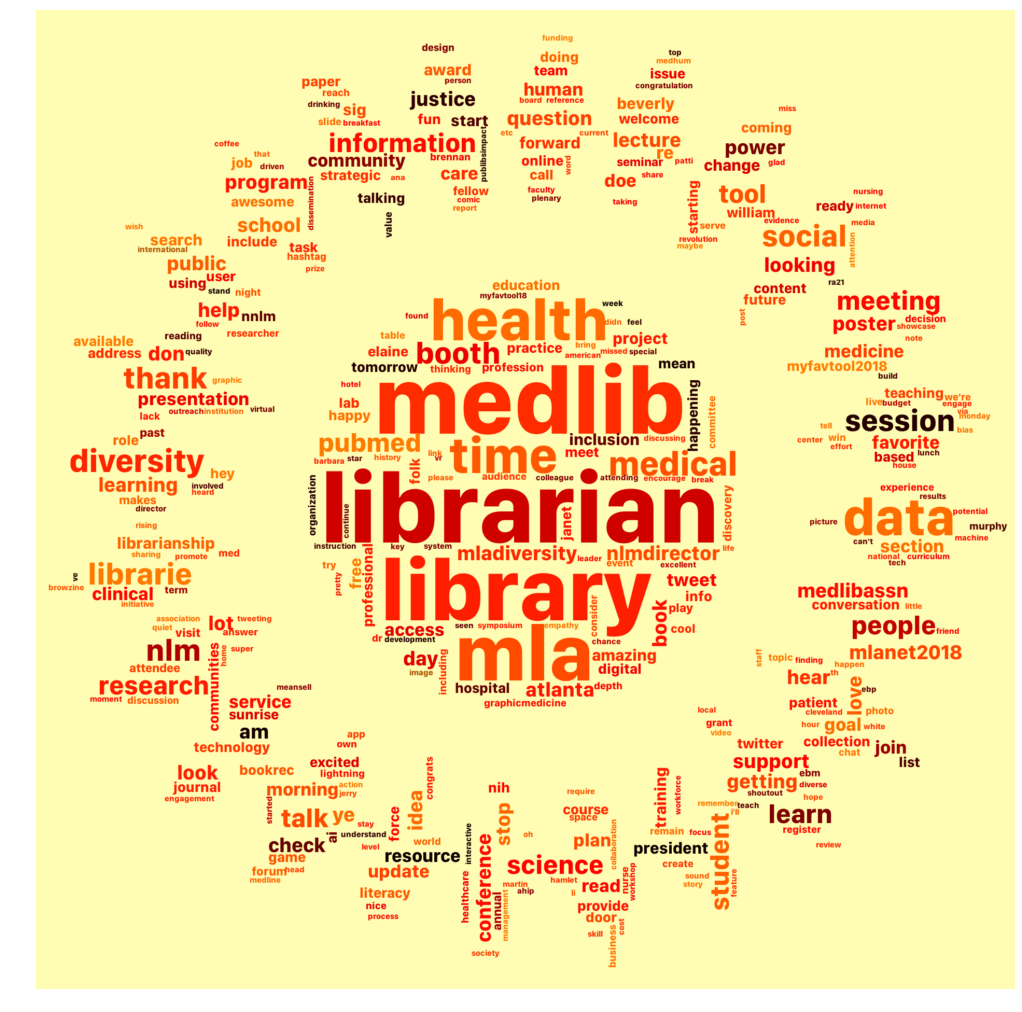

<Figure size 720x720 with 0 Axes>

In [91]:
# show word cloud
plt.figure(figsize=(18,18))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(10,10))
plt.show();

In [92]:
# store to file
wc.to_file("sun.png");

### Create second wordcloud for dual-image

In [40]:
# get the darker colours from the "Reds" and "autumn" cmaps:
colors2 = plt.cm.hot(np.linspace(0.5, 1, 128))
colors3 = plt.cm.autumn(np.linspace(0.5, 1, 256))

# stacking the 2 arrays row-wise
colors = np.vstack((colors3, colors2))

# generating a smoothly-varying LinearSegmentedColormap
cmap2 = mcolors.LinearSegmentedColormap.from_list('colormap', colors)

In [41]:
wc2 = WordCloud(mask=np.array(Image.open("mask_moon.jpg")),
               font_path="/System/Library/Fonts/SFCompactDisplay-Bold.otf",
               background_color="navy", colormap=cmap2,
               #background_color="#FFE563",  colormap="inferno",
               # background_color="#FFE563", colormap=phoenix_cmap,
               # background_color="#FFE563", colormap="hot",
               # background_color="#FFE563",  colormap="gnuplot",
               # background_color="#FFFCB3",  colormap="autumn",
               stopwords=get_stopwords(stop_tweeters=True), collocations=False,
               max_words=2000, relative_scaling=0.4,
               width=500, height=500, scale=4   # bigger scale means bigger image rendered. same with width and height
              )
# generate word cloud
wc2.generate(" ".join(after_hours_noRT));

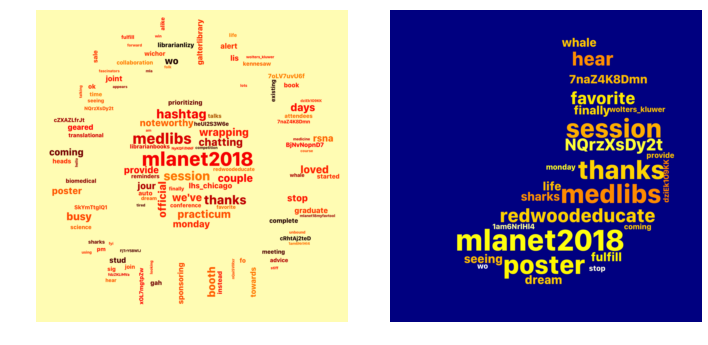

In [42]:
# show two figures side by side:
fig = plt.figure(figsize=(10,9))
ax1 = fig.add_subplot(121, )
ax1.imshow(wc, interpolation='bilinear')
ax1.axis("off")

ax2 = fig.add_subplot(122)
ax2.imshow(wc2, interpolation='bilinear')
ax2.axis("off")

#plt.figure(figsize=(10,10))
plt.tight_layout()
plt.savefig("night_and_day.png", transparent=True)
plt.show()

### Look at the top 50 words

In [43]:
# provides a sorted list of words and their frequencies
top50 = sorted(wc.words_.items(), key=lambda x: x[1], reverse=True)

In [44]:
refactored=list(zip(*top50))
s_wordfreq = pd.Series(data=refactored[1], index=refactored[0])

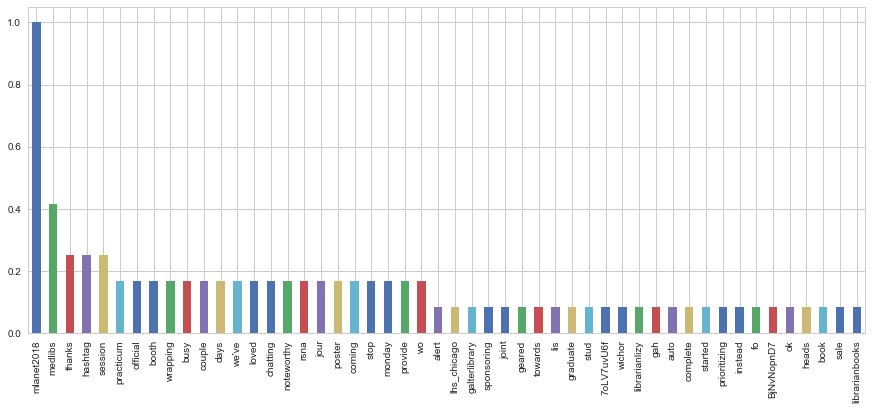

In [45]:
s_wordfreq[:50].plot.bar(figsize=(15,6))

---
---
# Appendix 1
## analysis of communication between members
*using mentions of twitter handles to build network of communication*

> I have not (yet) used or touched any of this for MLA'18 - I brought it across from MLA'17, and may yet do something here, but no promises! If you wish to contribute, feel free!

In [46]:
tweets["handles"] = tweets["tknzd"].apply(lambda x: [t for t in x if t[0] == "@" and len(t) > 1])

This next step was tricky, because the apply function could not receive the raw list, without it matching the shape of the original dataframe. The answer turned out to be, convert the list into a series with a single index, and return that instead. 

The following cell looks for twitter handles in the tokenized tweets, and creates a list of tuples - each tuple containing the tweeting handle, followed by the handle they mentioned.

In [47]:
def join_users(s):
    #print(s)
    
    results = []
    for h in s["handles"]:
        results.append(("@" + s["user.screen_name"], h))
    results = results
    #print( results)
    #print("#" * 12)
    return pd.Series({"results":results})
                     
tweets["connections"] = tweets.apply(join_users, axis=1)

In [48]:
print(tweets.shape)
tweets.head(3)

(33, 16)


,created_at,favorite_count,in_reply_to_status_id,in_reply_to_user_id,retweet_count,retweeted,text,truncated,user.id,user.screen_name,tknzd,is_retweet,is_reply,creation_hour,handles,connections
id,,,,,,,,,,,,,,,,
998950227808841729,2018-05-22 11:34:28,0,NaN,NaN,0,False,Practicum Alert: @LHS_Chicago &amp; @galterlib...,True,18999920,kristiholmes,"[practicum, alert, :, @lhs_chicago, &, @galter...",False,False,11,"[@lhs_chicago, @galterlibrary]","[(@kristiholmes, @lhs_chicago), (@kristiholmes..."
998949659715522565,2018-05-22 11:32:13,2,9.989486e+17,20427463.0,0,False,@wichor @LibrarianLizy Gah! My auto-complete h...,True,343416122,oxpeter,"[@wichor, @librarianlizy, gah, !, my, auto-com...",False,True,11,"[@wichor, @librarianlizy]","[(@oxpeter, @wichor), (@oxpeter, @librarianlizy)]"
998914903460204550,2018-05-22 09:14:06,0,NaN,NaN,1,False,RT @ChrisTheCat: @krafty Official hashtag is #...,False,30585609,NoetheMatt,"[rt, @christhecat, :, @krafty, official, hasht...",True,False,9,"[@christhecat, @krafty]","[(@NoetheMatt, @christhecat), (@NoetheMatt, @k..."


In [49]:
# print to csv:
handle = open("twitter_connections.csv", 'w')
pairs = [ t for l in tweets.connections.values for t in l]
cnt = Counter()
for author,mention in pairs:
    cnt[(author,mention)] += 1
for author,mention in set(pairs):
    handle.write("%s,%s,%d\n" % (author, mention,cnt[(author,mention)]))
handle.close()

## LDA analysis
_from WikiPedia:_

In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's creation is attributable to one of the document's topics. LDA is an example of a topic model and was first presented as a graphical model for topic discovery by David Blei, Andrew Ng, and Michael I. Jordan in 2003. Essentially the same model was also proposed independently by J. K. Pritchard, M. Stephens, and P. Donnelly in the study of population genetics in 2000. Both papers have been highly influential, with 16488 and 18170 citations respectively by December 2016.

In [50]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

we need to create a matrix of tokens and their counts for each tweet. During this creation process, the LDA example eliminates words present in > 95% of articles, or less than 2 articles.

We also need to clean the word set for stop words.

In [51]:
tweets["tknzd_cleaned"] = tweets.tknzd.apply(lambda x: [w for w in x if (
                                                                w not in get_stopwords()
                                                                        ) & (
                                                                bool(re.search("\w", w))
                                                                        ) ])

In [52]:
tweets.head()

,created_at,favorite_count,in_reply_to_status_id,in_reply_to_user_id,retweet_count,retweeted,text,truncated,user.id,user.screen_name,tknzd,is_retweet,is_reply,creation_hour,handles,connections,tknzd_cleaned
id,,,,,,,,,,,,,,,,,
998950227808841729,2018-05-22 11:34:28,0,NaN,NaN,0,False,Practicum Alert: @LHS_Chicago &amp; @galterlib...,True,18999920,kristiholmes,"[practicum, alert, :, @lhs_chicago, &, @galter...",False,False,11,"[@lhs_chicago, @galterlibrary]","[(@kristiholmes, @lhs_chicago), (@kristiholmes...","[practicum, alert, @lhs_chicago, @galterlibrar..."
998949659715522565,2018-05-22 11:32:13,2,9.989486e+17,20427463.0,0,False,@wichor @LibrarianLizy Gah! My auto-complete h...,True,343416122,oxpeter,"[@wichor, @librarianlizy, gah, !, my, auto-com...",False,True,11,"[@wichor, @librarianlizy]","[(@oxpeter, @wichor), (@oxpeter, @librarianlizy)]","[@wichor, @librarianlizy, gah, auto-complete, ..."
998914903460204550,2018-05-22 09:14:06,0,NaN,NaN,1,False,RT @ChrisTheCat: @krafty Official hashtag is #...,False,30585609,NoetheMatt,"[rt, @christhecat, :, @krafty, official, hasht...",True,False,9,"[@christhecat, @krafty]","[(@NoetheMatt, @christhecat), (@NoetheMatt, @k...","[@christhecat, @krafty, official, hashtag, #ml..."
998913093538369537,2018-05-22 09:06:55,3,9.989127e+17,13447862.0,1,False,"@krafty Official hashtag is #mlanet18, NOT #ml...",False,14758570,ChrisTheCat,"[@krafty, official, hashtag, is, #mlanet18, ,,...",False,True,9,[@krafty],"[(@ChrisTheCat, @krafty)]","[@krafty, official, hashtag, #mlanet18, #mlane..."
998912748414259202,2018-05-22 09:05:32,0,NaN,NaN,0,False,Ok #medlibs is it #mlanet18 or #mlanet2018,False,13447862,krafty,"[ok, #medlibs, is, it, #mlanet18, or, #mlanet2...",False,False,9,[],[],"[ok, #medlibs, #mlanet18, #mlanet2018]"


In [53]:
tokenset = tweets.tknzd_cleaned.reset_index()
s = tokenset.apply(lambda x: pd.Series(x['tknzd_cleaned']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'tkns'
tokendf = tokenset.drop('tknzd_cleaned', axis=1).join(s)
tokendf["present"] = 1
print(tokendf.shape)
tokendf.head()

(315, 3)


,id,tkns,present
0,998950227808841729,practicum,1
0,998950227808841729,alert,1
0,998950227808841729,@lhs_chicago,1
0,998950227808841729,@galterlibrary,1
0,998950227808841729,co-sponsoring,1


In [54]:
tweetarray = pd.pivot_table(tokendf.reset_index(), index='id', columns='tkns', values='present', )
tweetarray = tweetarray.fillna(0)
print(tweetarray.shape)
tweetarray = tweetarray[[x for x in tweetarray.columns if (
                                            tweetarray[x].sum() > 1
                                                        ) & (
                                            tweetarray[x].sum() < 0.95 * len(tweetarray[x])
                                                        ) ]]
print(tweetarray.shape)
tweetarray.head()

(33, 129)
(33, 54)


tkns,#librarianbooks,#medlibs,#mlanet18,#mlanet2018,126,2018,21,323,50,@covidence,...,stop,talking,thanks,tired,unbound,using,we've,wo,world-class,wrapping
id,,,,,,,,,,,,,,,,,,,,,
996234369198116864,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
996234637079928833,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
996235434920415233,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
996380615992905728,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
997475694438469632,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [55]:
%%time
lda = LatentDirichletAllocation(n_topics=20, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tweetarray)

feature_names = tweetarray.columns

CPU times: user 49 ms, sys: 2.34 ms, total: 51.3 ms
Wall time: 51 ms


/Users/poxley/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [56]:
def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
print_top_words(lda, feature_names)

Topic #0:
#mlanet18 #medlibs #mlanet2018 book #librarianbooks 50 https://t.co/heUI2S3W6e 126 sale heads booth @librariansharpe session thanks wo busy @krafty chatting 21 course
Topic #1:
#mlanet2018 21 provide monday session do: coming stop @covidence world-class medicine hello booth 323 forward unbound wo looking talking 2018
Topic #2:
#mlanet18 #mlanet2018 hashtag official thanks @pfanderson tired @krafty appears course using folk fyi https://t.co/FjTrY5BWlJ fascinators #medlibs busy wo wrapping jour
Topic #3:
126 #medlibs chatting jour hashtag thanks world-class heads book talking 323 https://t.co/heUI2S3W6e @covidence tired do: using official 21 couple unbound
Topic #4:
tired 21 do: world-class course fascinators @librariansharpe provide #mlanet2018 folk mla https://t.co/FjTrY5BWlJ @krafty jour busy couple days #librarianbooks forward monday
Topic #5:
@krafty fascinators 126 couple @covidence session https://t.co/FjTrY5BWlJ noteworthy 50 book #medlibs provide coming hello #mlanet18

To assign each tweet to one of the groups, transform the tweet array using the LDA model, which provides the assignment score for each group for each tweet.

In [57]:
tr_tweetarray = lda.transform(tweetarray)

In [58]:
tr_tweetarray.shape

(33, 20)

In [59]:
assignmentdf = pd.DataFrame(tr_tweetarray)
assignmentdf["best"] = assignmentdf.idxmax(axis=1)
assignmentdf["tweet"] = tweetarray.index
assignmentdf = assignmentdf.set_index("tweet")
assignmentdf.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,best
tweet,,,,,,,,,,,,,,,,,,,,,
996234369198116864,0.005000,0.905000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,...,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,1
996234637079928833,0.004545,0.913636,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,...,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,1
996235434920415233,0.004545,0.913636,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,...,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,1
996380615992905728,0.004545,0.913636,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,...,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,0.004545,1
997475694438469632,0.005000,0.905000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,...,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,1


In [60]:
assignmentdf["gt_02"] = assignmentdf[assignmentdf > 0.2].count(axis=1)

In [61]:
assignmentdf["gt_02"].describe()

count    33.000000
mean      1.515152
std       0.667140
min       0.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       2.000000
Name: gt_02, dtype: float64

In [62]:
handle = open("twitter_distances.txt", 'w')
for topic in assignmentdf.columns[:-1]:
    for tweet in assignmentdf[topic].index:
        handle.write("%s,%s,%.6f\n" % (topic, tweet, assignmentdf[topic][tweet]))
handle.close()

In [63]:
for x in assignmentdf[0].index[:10]:
    print(assignmentdf[0][x])

0.00500000004261
0.00454545457643
0.00454545457643
0.00454545457643
0.00500000004261
0.00454545457643
0.0100000002118
0.00833333342561
0.00555555559836
0.00500000003513
